# Count Relevant Expressions in Annual Reports

Having data in a structured and organized way enables deeper analysis and understanding of information. An example, is the analysis of specific keywords in annual reports to know the subjects in which companies focus their attention and investments along the time.

The Konfuzio SDK allows to do this by posting annotations in documents of your Konfuzio project. These annotations can then be downloaded in a structured way, associating each annotation to a certain label and document.

This allows different possible analysis. This tutorial guides you through how to identify and count pre-specified expressions in documents.

The aim is to analyse how much sustainability plays a role in the annual reports of german companies over a certain time span, particularly in relation to the appearance of the Covid-19 pandemic.

## 1. Install and initialize the Konfuzio SDK package


Start by installing and initializing the konfuzio sdk package.  

To use the package, please also register or sign in on app.konfuzio.com. 
Find more information in the readme of the [repository](https://github.com/konfuzio-ai/document-ai-python-sdk).

In [ ]:
!pip install konfuzio-sdk

In [ ]:
!konfuzio_sdk init

You also need to import the required packages shown below.

In [ ]:
import glob
import os
import re
import matplotlib.pyplot as plt
import pandas as pd
from konfuzio_sdk import SUPPORTED_FILE_TYPES
from konfuzio_sdk.data import Project, Annotation, Document, Label
from konfuzio_sdk.utils import get_file_type

## 2. Initiate the project 

Initiating the project might take some time if you use huge file volumes.  
The files will be stored locally in the folder you specified before which is "data_[project_id]" by default.

In [ ]:
my_project = Project(id_=YOUR_PROJECT_ID)

Upload your documents using the following code.

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
# filter the documents by the supported file types
files_to_check = [f for f in glob.glob('*') if os.path.isfile(f) and not f.endswith('.py')]
files_in_dir = []

for file_path in files_to_check:
    try:
        file_type = get_file_type(file_path)
        if file_type in SUPPORTED_FILE_TYPES:
          files_in_dir.append(file_path)
    except NotImplemented:
      continue

In [ ]:
for doc_file in files_in_dir:
    Document(file_path=doc_file, project=my_project).save()

Note:  

If you prefer, use the example documents in the example folder with sample documents provided [here](https://drive.google.com/drive/folders/1iWPBdxHqR8j8CWUdbVHO7OzIxZsOXe-l).

The documents are annual reports from companies which are part of the prime standard (full list of companies in prime standard can be found [here](https://www.deutsche-boerse-cash-market.com/dbcm-de/instrumente-statistiken/statistiken/gelistete-unternehmen)).   

Alternatively, you can do this step directly on the Konfuzio Server by uploading the documents there.  
For more details take a look [here](https://help.konfuzio.com/documents/receipt/index.html#upload-receipts).

Update your project to have the information of the documents after being processed by the server.

In [ ]:
my_project.update()

Get the documents from the project.

In [ ]:
documents = my_project.get_documents_from_project()

Check how many documents there are.

In [ ]:
print(len(documents))

## 3. Specify the expressions you want to count

Our aim is to count expressions related to sustainability (here: _climate_expressions_) and expressions related to pandemics (here: _pandemic_expressions_).  
Hence, we specify certain words and expressions related to these subjects.   These expressions will then be searched in the documents of the project to find exact matches. However, there is flexibility for lower- or uppercases. 

In [ ]:
# List of climate expressions to match
climate_expressions = [re.compile("climate change|climate crisis|climate emergency|climate breakdown", re.I),
                       re.compile("global warming|global heating", re.I),
                       re.compile("Greenhouse Gas", re.I),
                       re.compile("carbon emission", re.I),
                       re.compile("renewable energy|renewable sources", re.I)]

In [ ]:
# List of pandemic expressions to match
pandemic_expressions = [re.compile("Corona", re.I),
                     re.compile("Covid", re.I),
                     re.compile("pandemic", re.I),
                     re.compile("lockdown", re.I)]

## 4. Define the labels in the project

As we have expressions related to different subjects, we want to create a label for each one.  

To do this, start by setting up a label set on app.konfuzio.com (_Label sets -> + Add Label Set_).
It is important and necessary that each new annotation gets assigned to a new section. Therefore, tick the box "Has multiple sections" to achieve this. 

Update your project to get the new label set.

In [ ]:
my_project.update()

Get the ID of the label set.

In [ ]:
label_set = [label_set for label_set in my_project.label_sets if not label_set.is_default][0]

Now, you can add labels to your respective label_set.
These labels serve as categories or containers for your annotations. In our example, we cluster our annotations into expressions either related to pandemic or to sustainability. Therefore, we create two labels "Pandemic" and "Climate" to allocate the annotations accordingly. Down below, we define the label names of the project we want to use and match them with the existing ones in our project for the further proceeding.


In [ ]:
# labels for which we want to cluster the expressions
labels_names = ['Pandemic', 'Climate']

In [ ]:
for label in labels_names:
    Label(project=my_project, text=label, label_sets=[label_set]).save()

To confirm that the labels exist in the project:

In [ ]:
my_project.update()

print(f"Current labels in your project:\n{my_project.labels}")

Collect the defined labels and the correspondent label_set.

In [ ]:
# labels defined in the Konfuzio project that match the ones we want
labels = [label for label in my_project.labels if label.name in labels_names]

# correspondent label_sets
label_sets = [my_label.label_sets[0] for my_label in labels]

## 5. Find matches for the expressions in the documents

Now we find expressions in the documents which exactly match the expressions we defined above.  
If there is a match, it will be saved as an annotation in a separate section in the documents and can be viewed on app.konfuzio.com in the SmartView (https://app.konfuzio.com/admin/server/document/) of the respective document.  
If there are separate expressions next to each other in one document, they are counted as separate ones although they could be viewed as one single expression.

In [ ]:
# find matches for each label in each document and save the annotations in the corresponding documents
expressions = {'Climate': climate_expressions, 'Pandemic': pandemic_expressions}

for document in documents:
    for label, label_set in zip(labels, label_sets):
    
        for exp in expressions[label.name]:
            matches = [(m.start(0), m.end(0)) for m in re.finditer(exp, document.text)]
        
            for match in matches:
                annotation_obj = Annotation(
                    document=document,
                    section=None,
                    document_id=document.id,
                    start_offset=match[0],
                    end_offset=match[1],
                    label=label,
                    label_set_id=label_set.id,
                    accuracy=1.0,
                    is_correct=True,
                    revised=True,
                )
                
                _ = annotation_obj.save()

After the annotations have been created online, update the documents with the posted annotations. 

In [ ]:
for document in documents:
    document.get_document_details(update=True)

Let's check how many matches were found in the first document.  
You can find the annotations of a document using the method **annotations()**.

In [ ]:
print(len(documents[0].annotations()))

## 6. Data analysis

Let's have a quick look into how many matches were found.

The following provides you with the annotations per label for each of our respective documents separately, giving you the opportunity to analyze the annotations for the individual documents. 

In [ ]:
# count of annotations per document and per label
print("Annotations per document and per label:")
for doc in documents:
    count_dict_doc= {}
    print("\n{}:".format(doc))

    for annotation in doc.annotations():
        label_name = annotation.label.name
        if label_name in labels_names:
            if label_name in count_dict_doc.keys():
                count_dict_doc[label_name] += 1
            else:
                count_dict_doc[label_name] = 1
                
    print(count_dict_doc)

The Annotations are now also posted on app.konfuzio.com. You can view them in the Smartview there.  
To do a more complete and extensive analysis and to get a first glance about what is possible with the results we achieved with this tutorial, you can either use the provided code down below or you can export the information from the Konfuzio server by downloading the data as a csv file.

To download the csv file, please follow [these](https://help.konfuzio.com/integrations/csv/index.html) steps.

This csv provides you with further possibilities to work with the data and draw conclusions from it.

In this example we choose to analyze the relation between the occurences of sustainability and pandemic expressions, hence whether companies decreased their attention to sustainability issues with the arise of a global pandemic. In the code provided below, you can take a look at a first analysis drawn from the data we achieved with this analysis of the annual reports of the companies. 

Retrieve different information from the documents of your Konfuzio project and create a dataframe with these information for a better overview:

In [ ]:
docs_info = []

for doc in documents:
  annot = doc.annotations()
  doc_info = {'name': doc.name,
              'ISIN': doc.name.split("_")[0],
              'year': doc.name.split("_")[1][:4],
              'ID': doc.id,
              'URL': doc.file_url,
              'status': doc.dataset_status,
              'n_pages': doc.number_of_pages,
              'topics_climate': len([a for a in annot if a.label.name == 'Climate']),
              'topics_pandemic': len([a for a in annot if a.label.name == 'Pandemic'])}
  
  docs_info.append(doc_info)

df = pd.DataFrame(data=docs_info)
df.head()

Retrieve the total number of pages of all annual reports present in the dataset as well as the total count of climate and pandemic expressions.

In [ ]:
sum_pages = df['n_pages'].sum()
print("Total sum of pages in dataset: {}.".format(sum_pages))
sum_topics_climate = df["topics_climate"].sum()
print("Total sum of topics_climate: {}.".format(sum_topics_climate))
sum_topics_pandemic = df["topics_pandemic"].sum()
print("Total sum of topics_pandemic: {}.".format(sum_topics_pandemic))

Total sum of pages in dataset: 2096.
Total sum of topics_climate: 61.
Total sum of topics_pandemic: 354.


Furthermore, group the number of climate and pandemic expressions by year to analyze the development of occurrences of each one over the timespan from 2010 to 2020:

In [ ]:
def count_per_year(dataframe, label):
    grouped = dataframe.groupby('year')['topics_' + label].sum()
    grouped_df = {'count_' + label: grouped}
    grouped_df = pd.DataFrame(data=grouped_df)
    grouped_df.plot(kind = 'bar')
    plt.title(f'Number of {label} expressions per year')

In [ ]:
count_per_year(df, 'climate')
count_per_year(df, 'pandemic')

You will get two figures similar to the following ones:

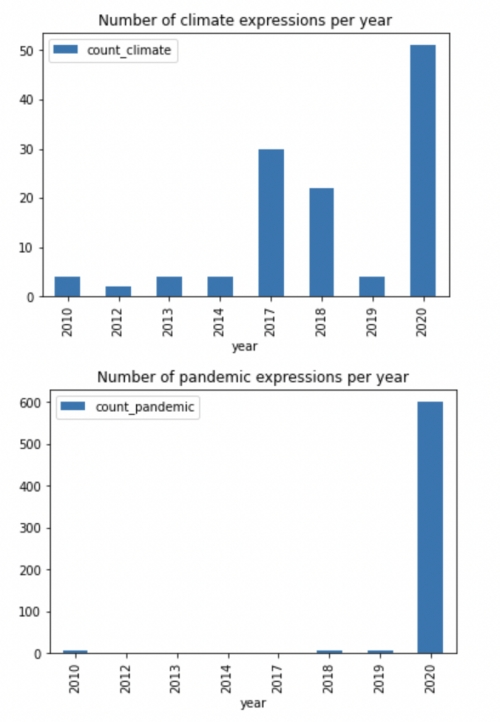

As we can recognize, sustainability still played an important role for companies with the issue even increasing in importance and occurence over the years. As expected, pandemic expressions strongly rose with the beginning and emergence of the Covid-19 pandemic.  

For further background information and additional application possibilities, as well as specific analysises of the different sectors during the timespan analyzed, we kindly want to refer to our blogpost coming soon [here](https://konfuzio.com/).